In [1]:
import cv2, ast
import torchvision
import matplotlib.pyplot as plt
import torch.nn.init as init
import torch
import torch.nn as nn
import numpy as np
import pandas as pd 
from torchvision import transforms
from torch.autograd import Variable
import torch.functional as F
import pickle
import torch.nn.functional as F
import segmentation_models_pytorch as smp
from PIL import Image, ImageFilter

In [2]:
df = pd.read_pickle('lung_cancer_train.pkl')

In [3]:
df

,label1,mask,hu_array,hu_array_old
0,LR2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,..."
1,LR2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,..."
2,LR2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,..."
3,LR2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,..."
4,LR2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,..."
...,...,...,...,...
703,LR4B,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1015.0, -1024.0, -972.0, -975.0, -1013.0, -..."
704,LR4B,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1022.0, -1024.0, -957.0, -987.0, -1022.0, -..."
705,LR4B,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -951.0, -998.0, -1019.0, -..."
706,LR4B,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1009.0, -968.0, -1022.0, -1007.0, ..."


In [4]:
from skimage.transform import resize
def crop_roi(mask, hu_array):
    # Находим область интереса (RoI) путем умножения бинарной маски на массив Hounsfield Units (HU)
    roi = mask * hu_array
    
    # Проверяем, есть ли ненулевые элементы в RoI
    if np.any(roi):
        # Находим границы RoI для обрезки
        nonzero_indices = np.nonzero(roi)
        min_row, max_row = np.min(nonzero_indices[0]), np.max(nonzero_indices[0])
        min_col, max_col = np.min(nonzero_indices[1]), np.max(nonzero_indices[1])

        # Обрезаем RoI до размера 64x64, сохраняя масштаб области рака
        roi_cropped = roi[min_row-10:max_row+10, min_col-10:max_col+10]
        roi_resized = resize(roi_cropped, (64, 64), anti_aliasing=True)
    else:
        # Если RoI пуста, создаем пустое изображение размера 64x64
        roi_resized = np.zeros((64, 64))
    
    return roi_resized


In [5]:
# Применяем функцию crop_roi к каждой строке датафрейма и создаем новый столбец roi
df['roi'] = df.apply(lambda row: crop_roi(row['mask'], row['hu_array_old']), axis=1)


In [6]:
# Define a function to replace 0 with 2000 in a 64x64 NumPy array
def replace_zeros(arr):
    return np.where(arr == 0, 255, arr)

# Apply the function to each element in the 'roi' column of train_df
df['roi'] = df['roi'].apply(replace_zeros)

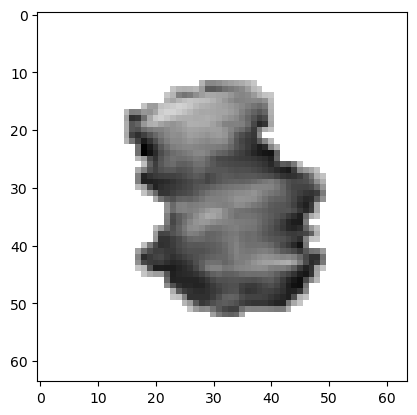

In [10]:
plt.imshow(df['roi'][700], cmap = "gray")

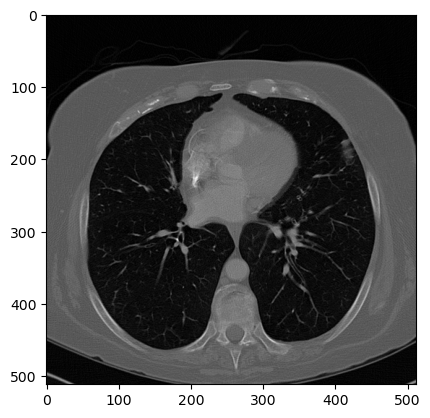

In [8]:
plt.imshow(df['hu_array_old'][700], cmap = "gray")

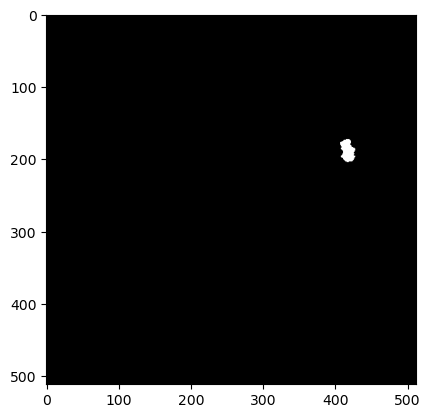

In [9]:
plt.imshow(df['mask'][700], cmap = "gray")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os
import torch.nn.functional as F
from tqdm import tqdm

In [3]:
class ResidualLayer(nn.Module):
    def __init__(self, in_dim, hidden_dim, res_hidden_dim):
        super().__init__()

        self.res_block = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(in_dim, res_hidden_dim, kernel_size=3, stride=1, padding=1, bias=False),

            nn.ReLU(),
            nn.Conv2d(res_hidden_dim, hidden_dim, kernel_size=1, stride=1, bias=False)
        )

    def forward(self, x):
        x = x + self.res_block(x)
        return x

In [4]:
class ResidualStack(nn.Module):
    def __init__(self, in_dim, hidden_dim, res_hidden_dim, n_res_layers):
        super().__init__()

        self.n_res_layers = n_res_layers
        self.stack = nn.ModuleList(
            [ResidualLayer(in_dim, hidden_dim, res_hidden_dim)] * n_res_layers
        )
        self.act = nn.ReLU()

    def forward(self, x):
        for layer in self.stack:
            x = layer(x)
        x = self.act(x)
        return x

In [5]:
class Encoder(nn.Module):
    def __init__(self, in_channels, hidden_dim, res_hidden_dim, n_res_layers):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, hidden_dim // 2, kernel_size=4,
                               stride=2, padding=1)
        self.conv2 = nn.Conv2d(hidden_dim // 2, hidden_dim, kernel_size=4,
                               stride=2, padding=1)
        self.conv3 = nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3,
                               stride=1, padding=1)

        self.residual_stack = ResidualStack(hidden_dim, hidden_dim, res_hidden_dim,
                                            n_res_layers)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.act(x)

        x = self.conv2(x)
        x = self.act(x)

        x = self.conv3(x)
        return self.residual_stack(x)

In [6]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super().__init__()

        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost

        self.embedding = nn.Embedding(self.num_embeddings, self.embedding_dim)
        self.embedding.weight.data.uniform_(-1.0 / self.num_embeddings,
                                            1.0 / self.num_embeddings)

    def forward(self, x):
        x = x.permute(0, 2, 3, 1).contiguous()
        x_shape = x.shape

        flat_x = x.view(-1, self.embedding_dim)

        distances = (torch.sum(flat_x**2, dim=1, keepdim=True)
                    + torch.sum(self.embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_x, self.embedding.weight.T))

        #Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings,
                                device=x.device)
        encodings.scatter_(1, encoding_indices, 1)

        #quantize and unflatten
        quantized = torch.matmul(encodings, self.embedding.weight).view(x_shape)

        #Loss
        e_latent_loss = F.mse_loss(quantized.detach(), x)
        q_latent_loss = F.mse_loss(quantized, x.detach())
        loss = q_latent_loss + self.commitment_cost * e_latent_loss

        quantized = x + (quantized - x).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings, encoding_indices

In [7]:
class Decoder(nn.Module):
    def __init__(self, in_channels, hidden_dim, res_hidden_dim, n_res_layers):
        super().__init__()

        self.conv_transpose1 = nn.ConvTranspose2d(in_channels, hidden_dim, kernel_size=3,
                               stride=1, padding=1)
        self.residual_stack = ResidualStack(hidden_dim, hidden_dim, res_hidden_dim,
                                            n_res_layers)
        self.conv_transpose2 = nn.ConvTranspose2d(hidden_dim, hidden_dim//2,
                                                  kernel_size=4, stride=2, padding=1)
        self.conv_transpose3 = nn.ConvTranspose2d(hidden_dim//2, 1,
                                                  kernel_size=4, stride=2, padding=1)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.conv_transpose1(x)
        x = self.residual_stack(x)
        x = self.conv_transpose2(x)
        x = self.act(x)
        return self.conv_transpose3(x)

In [8]:
class Model(nn.Module):
    def __init__(self, hidden_dim, res_hidden_dim, n_res_layers,
                   num_embeddings, embedding_dim, commitment_cost):
        super().__init__()

        self.encoder = Encoder(1, hidden_dim, res_hidden_dim, n_res_layers)
        self.pre_vq_conv = nn.Conv2d(hidden_dim, embedding_dim,
                                     kernel_size=1, stride=1)
        self.vq_vae = VectorQuantizer(num_embeddings, embedding_dim, commitment_cost)
        self.decoder = Decoder(embedding_dim, hidden_dim, res_hidden_dim, n_res_layers)

    def forward(self, x):
        z = self.encoder(x)
        z = self.pre_vq_conv(z)

        loss, quantized, perplexity, _, _ = self.vq_vae(z)
        x_reconstructed = self.decoder(quantized)

        return loss, x_reconstructed, perplexity

In [9]:
class CancerDataset(Dataset):
    def __init__(self, df, transform=None):
        super().__init__()

        self.data = df['roi']
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        roi = self.data[index]

        if self.transform:
            augmented = self.transform(image=roi)
            roi = augmented['image']

        return roi


In [18]:
from sklearn.model_selection import train_test_split

# Разделение train_df на train_df и test_df в соотношении 80/20
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# Создание датасетов и загрузчиков данных
transform = A.Compose([
    A.Normalize(mean=0.5, std=1.0, max_pixel_value=255.0),
    ToTensorV2()
])

df_train = CancerDataset(train_df, transform)
df_test = CancerDataset(test_df, transform)

train_loader = DataLoader(df_train, batch_size=16, shuffle=True, num_workers=2)
test_loader = DataLoader(df_test, batch_size=16, shuffle=False, num_workers=2)


In [19]:
test_df

,label1,mask,hu_array,hu_array_old,roi
0,LR2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-2048.0, -2048.0, -2048.0, -2048.0, -2048.0,...","[[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 25..."
1,LR4B,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-2048.0, -2048.0, -2048.0, -2048.0, -2048.0,...","[[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 25..."
2,LR3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-2048.0, -2048.0, -2048.0, -2048.0, -2048.0,...","[[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 25..."
3,LR3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-2048.0, -2048.0, -2048.0, -2048.0, -2048.0,...","[[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 25..."
4,LR4B,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1001.0, -1001.0, -1001.0, -1001.0, -1001.0,...","[[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 25..."
...,...,...,...,...,...
137,LR4B,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-2048.0, -2048.0, -2048.0, -2048.0, -2048.0,...","[[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 25..."
138,LR2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-2048.0, -2048.0, -2048.0, -2048.0, -2048.0,...","[[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 25..."
139,LR4B,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1001.0, -1001.0, -1001.0, -1001.0, -1001.0,...","[[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 25..."
140,LR4B,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-2048.0, -2048.0, -2048.0, -2048.0, -2048.0,...","[[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 25..."


In [20]:
for img in tqdm(train_loader):
    z = 1

100%|██████████| 36/36 [00:00<00:00, 74.05it/s]


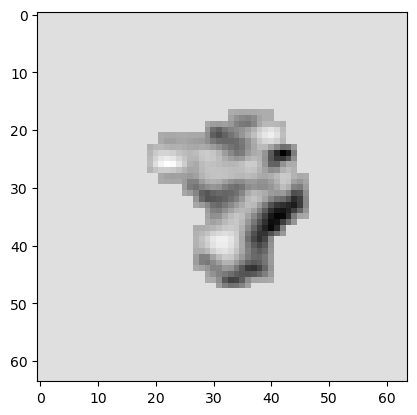

In [21]:
plt.imshow(img[0][0],cmap = "gray")

In [11]:
num_training_updates = 15000

hidden_dim = 256
res_hidden_dim = 32
n_res_layers = 2

embedding_dim = 64
num_embeddings = 512
commitment_cost = 0.05
learning_rate = 2e-4

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Model(hidden_dim, res_hidden_dim, n_res_layers,
              num_embeddings, embedding_dim, commitment_cost).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

In [13]:
print(sum(p.numel() for p in model.parameters()))

2004033


In [24]:
model.train()
train_res_recon_error = []
train_res_perplexity = []

for i in tqdm(range(num_training_updates)):
    data = next(iter(train_loader))
    data = data.to(device)
    optimizer.zero_grad()

    vq_loss, data_recon, perplexity = model(data)
    recon_error = F.mse_loss(data_recon, data)
    loss = recon_error + vq_loss
    loss.backward()

    optimizer.step()

    train_res_recon_error.append(recon_error.item())
    train_res_perplexity.append(perplexity.item())

    if (i+1) % 100 == 0:
        print('%d iterations' % (i+1))
        print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
        print('perplexity: %.3f' % np.mean(train_res_perplexity[-100:]))
        print()

  1%|          | 100/15000 [01:07<2:42:51,  1.52it/s]

100 iterations
recon_error: 0.301
perplexity: 2.417



  1%|▏         | 200/15000 [02:12<2:41:45,  1.52it/s]

200 iterations
recon_error: 0.140
perplexity: 1.856



  2%|▏         | 300/15000 [03:18<2:43:30,  1.50it/s]

300 iterations
recon_error: 0.144
perplexity: 1.776



  3%|▎         | 400/15000 [04:25<2:42:04,  1.50it/s]

400 iterations
recon_error: 0.149
perplexity: 1.448



  3%|▎         | 500/15000 [05:30<2:44:13,  1.47it/s]

500 iterations
recon_error: 0.124
perplexity: 1.769



  4%|▍         | 600/15000 [06:36<2:56:05,  1.36it/s]

600 iterations
recon_error: 0.093
perplexity: 2.416



  5%|▍         | 700/15000 [07:42<2:34:05,  1.55it/s]

700 iterations
recon_error: 0.085
perplexity: 2.385



  5%|▌         | 800/15000 [08:47<2:29:53,  1.58it/s]

800 iterations
recon_error: 0.076
perplexity: 2.323



  6%|▌         | 900/15000 [09:52<2:29:48,  1.57it/s]

900 iterations
recon_error: 0.076
perplexity: 2.394



  7%|▋         | 1000/15000 [10:56<2:32:48,  1.53it/s]

1000 iterations
recon_error: 0.072
perplexity: 2.607



  7%|▋         | 1100/15000 [12:02<2:32:17,  1.52it/s]

1100 iterations
recon_error: 0.068
perplexity: 2.933



  8%|▊         | 1200/15000 [13:07<2:41:51,  1.42it/s]

1200 iterations
recon_error: 0.067
perplexity: 3.589



  9%|▊         | 1300/15000 [14:14<2:38:47,  1.44it/s]

1300 iterations
recon_error: 0.065
perplexity: 4.283



  9%|▉         | 1400/15000 [15:19<2:51:09,  1.32it/s]

1400 iterations
recon_error: 0.062
perplexity: 4.153



 10%|█         | 1500/15000 [16:24<2:33:05,  1.47it/s]

1500 iterations
recon_error: 0.058
perplexity: 4.289



 11%|█         | 1600/15000 [17:29<2:30:48,  1.48it/s]

1600 iterations
recon_error: 0.056
perplexity: 4.497



 11%|█▏        | 1700/15000 [18:35<2:22:36,  1.55it/s]

1700 iterations
recon_error: 0.058
perplexity: 4.798



 12%|█▏        | 1800/15000 [19:42<2:22:09,  1.55it/s]

1800 iterations
recon_error: 0.056
perplexity: 4.912



 13%|█▎        | 1900/15000 [20:47<2:30:54,  1.45it/s]

1900 iterations
recon_error: 0.056
perplexity: 4.727



 13%|█▎        | 2000/15000 [21:53<2:14:55,  1.61it/s]

2000 iterations
recon_error: 0.054
perplexity: 4.509



 14%|█▍        | 2100/15000 [22:57<2:06:46,  1.70it/s]

2100 iterations
recon_error: 0.054
perplexity: 4.470



 15%|█▍        | 2200/15000 [24:02<2:06:11,  1.69it/s]

2200 iterations
recon_error: 0.054
perplexity: 4.471



 15%|█▌        | 2300/15000 [25:08<2:10:03,  1.63it/s]

2300 iterations
recon_error: 0.053
perplexity: 4.343



 16%|█▌        | 2400/15000 [26:13<2:17:15,  1.53it/s]

2400 iterations
recon_error: 0.052
perplexity: 4.366



 17%|█▋        | 2500/15000 [27:17<2:10:15,  1.60it/s]

2500 iterations
recon_error: 0.051
perplexity: 4.623



 17%|█▋        | 2600/15000 [28:22<2:20:39,  1.47it/s]

2600 iterations
recon_error: 0.051
perplexity: 5.242



 18%|█▊        | 2700/15000 [29:28<1:59:18,  1.72it/s]

2700 iterations
recon_error: 0.052
perplexity: 5.489



 19%|█▊        | 2800/15000 [30:34<2:05:43,  1.62it/s]

2800 iterations
recon_error: 0.051
perplexity: 5.425



 19%|█▉        | 2900/15000 [31:40<2:08:28,  1.57it/s]

2900 iterations
recon_error: 0.051
perplexity: 5.455



 20%|██        | 3000/15000 [32:45<2:05:29,  1.59it/s]

3000 iterations
recon_error: 0.049
perplexity: 5.475



 21%|██        | 3100/15000 [33:50<2:08:16,  1.55it/s]

3100 iterations
recon_error: 0.048
perplexity: 5.547



 21%|██▏       | 3200/15000 [34:55<2:03:03,  1.60it/s]

3200 iterations
recon_error: 0.048
perplexity: 5.576



 22%|██▏       | 3300/15000 [36:01<2:02:47,  1.59it/s]

3300 iterations
recon_error: 0.048
perplexity: 5.728



 23%|██▎       | 3400/15000 [37:08<1:54:47,  1.68it/s]

3400 iterations
recon_error: 0.046
perplexity: 5.959



 23%|██▎       | 3500/15000 [38:13<1:54:39,  1.67it/s]

3500 iterations
recon_error: 0.046
perplexity: 6.245



 24%|██▍       | 3600/15000 [39:20<2:14:01,  1.42it/s]

3600 iterations
recon_error: 0.045
perplexity: 6.620



 25%|██▍       | 3700/15000 [40:24<1:56:45,  1.61it/s]

3700 iterations
recon_error: 0.046
perplexity: 7.131



 25%|██▌       | 3800/15000 [41:26<1:57:57,  1.58it/s]

3800 iterations
recon_error: 0.044
perplexity: 7.239



 26%|██▌       | 3900/15000 [42:26<1:47:11,  1.73it/s]

3900 iterations
recon_error: 0.042
perplexity: 7.212



 27%|██▋       | 4000/15000 [43:27<1:47:13,  1.71it/s]

4000 iterations
recon_error: 0.042
perplexity: 7.224



 27%|██▋       | 4100/15000 [44:29<1:53:42,  1.60it/s]

4100 iterations
recon_error: 0.042
perplexity: 7.587



 28%|██▊       | 4200/15000 [45:30<1:42:51,  1.75it/s]

4200 iterations
recon_error: 0.042
perplexity: 7.514



 29%|██▊       | 4300/15000 [46:31<2:01:53,  1.46it/s]

4300 iterations
recon_error: 0.042
perplexity: 7.609



 29%|██▉       | 4400/15000 [47:32<1:49:46,  1.61it/s]

4400 iterations
recon_error: 0.042
perplexity: 7.796



 30%|███       | 4500/15000 [48:33<1:50:48,  1.58it/s]

4500 iterations
recon_error: 0.041
perplexity: 8.053



 31%|███       | 4600/15000 [49:34<1:48:57,  1.59it/s]

4600 iterations
recon_error: 0.040
perplexity: 8.812



 31%|███▏      | 4700/15000 [50:36<1:49:40,  1.57it/s]

4700 iterations
recon_error: 0.040
perplexity: 9.172



 32%|███▏      | 4800/15000 [51:37<1:42:14,  1.66it/s]

4800 iterations
recon_error: 0.039
perplexity: 9.534



 33%|███▎      | 4900/15000 [52:38<1:38:48,  1.70it/s]

4900 iterations
recon_error: 0.039
perplexity: 9.656



 33%|███▎      | 5000/15000 [53:40<1:37:23,  1.71it/s]

5000 iterations
recon_error: 0.039
perplexity: 9.679



 34%|███▍      | 5100/15000 [54:41<1:47:47,  1.53it/s]

5100 iterations
recon_error: 0.039
perplexity: 9.712



 35%|███▍      | 5200/15000 [55:43<1:35:11,  1.72it/s]

5200 iterations
recon_error: 0.037
perplexity: 9.805



 35%|███▌      | 5300/15000 [56:45<1:39:09,  1.63it/s]

5300 iterations
recon_error: 0.037
perplexity: 10.016



 36%|███▌      | 5400/15000 [57:48<1:38:17,  1.63it/s]

5400 iterations
recon_error: 0.035
perplexity: 9.916



 37%|███▋      | 5500/15000 [58:50<1:38:29,  1.61it/s]

5500 iterations
recon_error: 0.036
perplexity: 10.270



 37%|███▋      | 5600/15000 [59:52<1:36:17,  1.63it/s]

5600 iterations
recon_error: 0.036
perplexity: 10.419



 38%|███▊      | 5700/15000 [1:00:54<1:31:27,  1.69it/s]

5700 iterations
recon_error: 0.036
perplexity: 10.497



 39%|███▊      | 5800/15000 [1:01:57<1:43:36,  1.48it/s]

5800 iterations
recon_error: 0.035
perplexity: 10.568



 39%|███▉      | 5900/15000 [1:02:58<1:29:13,  1.70it/s]

5900 iterations
recon_error: 0.034
perplexity: 10.664



 40%|████      | 6000/15000 [1:03:59<1:27:32,  1.71it/s]

6000 iterations
recon_error: 0.034
perplexity: 10.856



 41%|████      | 6100/15000 [1:05:01<1:31:21,  1.62it/s]

6100 iterations
recon_error: 0.034
perplexity: 10.908



 41%|████▏     | 6200/15000 [1:06:03<1:30:26,  1.62it/s]

6200 iterations
recon_error: 0.034
perplexity: 11.082



 42%|████▏     | 6300/15000 [1:07:05<1:47:57,  1.34it/s]

6300 iterations
recon_error: 0.033
perplexity: 11.129



 43%|████▎     | 6400/15000 [1:08:07<1:26:51,  1.65it/s]

6400 iterations
recon_error: 0.032
perplexity: 11.040



 43%|████▎     | 6500/15000 [1:09:08<1:27:58,  1.61it/s]

6500 iterations
recon_error: 0.033
perplexity: 11.191



 44%|████▍     | 6600/15000 [1:10:09<1:32:19,  1.52it/s]

6600 iterations
recon_error: 0.032
perplexity: 11.256



 45%|████▍     | 6700/15000 [1:11:11<1:23:12,  1.66it/s]

6700 iterations
recon_error: 0.031
perplexity: 11.066



 45%|████▌     | 6800/15000 [1:12:13<1:28:34,  1.54it/s]

6800 iterations
recon_error: 0.032
perplexity: 11.220



 46%|████▌     | 6900/15000 [1:13:14<1:27:49,  1.54it/s]

6900 iterations
recon_error: 0.031
perplexity: 11.328



 47%|████▋     | 7000/15000 [1:14:15<1:24:50,  1.57it/s]

7000 iterations
recon_error: 0.030
perplexity: 11.311



 47%|████▋     | 7100/15000 [1:15:16<1:28:44,  1.48it/s]

7100 iterations
recon_error: 0.030
perplexity: 11.480



 48%|████▊     | 7200/15000 [1:16:17<1:14:41,  1.74it/s]

7200 iterations
recon_error: 0.031
perplexity: 11.519



 49%|████▊     | 7300/15000 [1:17:18<1:18:16,  1.64it/s]

7300 iterations
recon_error: 0.031
perplexity: 11.567



 49%|████▉     | 7400/15000 [1:18:19<1:17:39,  1.63it/s]

7400 iterations
recon_error: 0.028
perplexity: 11.519



 50%|█████     | 7500/15000 [1:19:20<1:14:32,  1.68it/s]

7500 iterations
recon_error: 0.030
perplexity: 11.735



 51%|█████     | 7600/15000 [1:20:20<1:12:32,  1.70it/s]

7600 iterations
recon_error: 0.030
perplexity: 11.886



 51%|█████▏    | 7700/15000 [1:21:22<1:11:11,  1.71it/s]

7700 iterations
recon_error: 0.028
perplexity: 12.128



 52%|█████▏    | 7800/15000 [1:22:22<1:10:03,  1.71it/s]

7800 iterations
recon_error: 0.028
perplexity: 12.347



 53%|█████▎    | 7900/15000 [1:23:23<1:12:21,  1.64it/s]

7900 iterations
recon_error: 0.028
perplexity: 12.419



 53%|█████▎    | 8000/15000 [1:24:25<1:13:50,  1.58it/s]

8000 iterations
recon_error: 0.026
perplexity: 12.439



 54%|█████▍    | 8100/15000 [1:25:25<1:14:52,  1.54it/s]

8100 iterations
recon_error: 0.027
perplexity: 12.554



 55%|█████▍    | 8200/15000 [1:26:27<1:11:48,  1.58it/s]

8200 iterations
recon_error: 0.035
perplexity: 12.377



 55%|█████▌    | 8300/15000 [1:27:28<1:06:44,  1.67it/s]

8300 iterations
recon_error: 0.031
perplexity: 12.683



 56%|█████▌    | 8400/15000 [1:28:28<1:05:11,  1.69it/s]

8400 iterations
recon_error: 0.026
perplexity: 12.831



 57%|█████▋    | 8500/15000 [1:29:30<1:07:54,  1.60it/s]

8500 iterations
recon_error: 0.025
perplexity: 12.936



 57%|█████▋    | 8600/15000 [1:30:31<1:05:13,  1.64it/s]

8600 iterations
recon_error: 0.026
perplexity: 12.996



 58%|█████▊    | 8700/15000 [1:31:33<1:05:33,  1.60it/s]

8700 iterations
recon_error: 0.026
perplexity: 13.053



 59%|█████▊    | 8800/15000 [1:32:33<1:03:07,  1.64it/s]

8800 iterations
recon_error: 0.026
perplexity: 13.010



 59%|█████▉    | 8900/15000 [1:33:34<1:06:43,  1.52it/s]

8900 iterations
recon_error: 0.024
perplexity: 13.132



 60%|██████    | 9000/15000 [1:34:36<1:00:18,  1.66it/s]

9000 iterations
recon_error: 0.025
perplexity: 13.172



 61%|██████    | 9100/15000 [1:35:37<57:35,  1.71it/s]  

9100 iterations
recon_error: 0.024
perplexity: 13.411



 61%|██████▏   | 9200/15000 [1:36:37<57:18,  1.69it/s]  

9200 iterations
recon_error: 0.024
perplexity: 13.280



 62%|██████▏   | 9300/15000 [1:37:40<58:16,  1.63it/s]  

9300 iterations
recon_error: 0.024
perplexity: 13.477



 63%|██████▎   | 9400/15000 [1:38:41<55:25,  1.68it/s]  

9400 iterations
recon_error: 0.024
perplexity: 13.500



 63%|██████▎   | 9500/15000 [1:39:42<53:00,  1.73it/s]  

9500 iterations
recon_error: 0.027
perplexity: 13.328



 64%|██████▍   | 9600/15000 [1:40:42<57:28,  1.57it/s]  

9600 iterations
recon_error: 0.023
perplexity: 13.412



 65%|██████▍   | 9700/15000 [1:41:44<52:55,  1.67it/s]  

9700 iterations
recon_error: 0.022
perplexity: 13.712



 65%|██████▌   | 9800/15000 [1:42:45<51:14,  1.69it/s]  

9800 iterations
recon_error: 0.023
perplexity: 14.086



 66%|██████▌   | 9900/15000 [1:43:46<49:07,  1.73it/s]  

9900 iterations
recon_error: 0.023
perplexity: 14.170



 67%|██████▋   | 10000/15000 [1:44:48<50:21,  1.65it/s]

10000 iterations
recon_error: 0.023
perplexity: 13.924



 67%|██████▋   | 10100/15000 [1:45:49<49:05,  1.66it/s]  

10100 iterations
recon_error: 0.021
perplexity: 14.192



 68%|██████▊   | 10200/15000 [1:46:50<53:30,  1.50it/s]

10200 iterations
recon_error: 0.021
perplexity: 14.305



 69%|██████▊   | 10300/15000 [1:47:52<47:04,  1.66it/s]

10300 iterations
recon_error: 0.023
perplexity: 14.314



 69%|██████▉   | 10400/15000 [1:48:52<45:14,  1.69it/s]

10400 iterations
recon_error: 0.021
perplexity: 14.412



 70%|███████   | 10500/15000 [1:49:55<48:38,  1.54it/s]

10500 iterations
recon_error: 0.021
perplexity: 14.551



 71%|███████   | 10600/15000 [1:50:58<45:51,  1.60it/s]

10600 iterations
recon_error: 0.020
perplexity: 14.518



 71%|███████▏  | 10700/15000 [1:51:58<43:23,  1.65it/s]

10700 iterations
recon_error: 0.021
perplexity: 14.502



 72%|███████▏  | 10800/15000 [1:53:00<48:28,  1.44it/s]

10800 iterations
recon_error: 0.020
perplexity: 14.352



 73%|███████▎  | 10900/15000 [1:54:02<47:34,  1.44it/s]

10900 iterations
recon_error: 0.020
perplexity: 14.377



 73%|███████▎  | 11000/15000 [1:55:02<41:44,  1.60it/s]

11000 iterations
recon_error: 0.021
perplexity: 14.470



 74%|███████▍  | 11100/15000 [1:56:05<39:54,  1.63it/s]

11100 iterations
recon_error: 0.021
perplexity: 14.416



 75%|███████▍  | 11200/15000 [1:57:07<39:04,  1.62it/s]

11200 iterations
recon_error: 0.019
perplexity: 14.708



 75%|███████▌  | 11300/15000 [1:58:08<39:05,  1.58it/s]

11300 iterations
recon_error: 0.019
perplexity: 14.762



 76%|███████▌  | 11400/15000 [1:59:10<35:06,  1.71it/s]

11400 iterations
recon_error: 0.018
perplexity: 14.577



 77%|███████▋  | 11500/15000 [2:00:12<37:47,  1.54it/s]

11500 iterations
recon_error: 0.018
perplexity: 14.722



 77%|███████▋  | 11600/15000 [2:01:13<36:07,  1.57it/s]

11600 iterations
recon_error: 0.019
perplexity: 14.991



 78%|███████▊  | 11700/15000 [2:02:14<33:02,  1.66it/s]

11700 iterations
recon_error: 0.018
perplexity: 15.120



 79%|███████▊  | 11800/15000 [2:03:15<33:26,  1.60it/s]

11800 iterations
recon_error: 0.019
perplexity: 14.880



 79%|███████▉  | 11900/15000 [2:04:16<29:26,  1.76it/s]

11900 iterations
recon_error: 0.018
perplexity: 15.141



 80%|████████  | 12000/15000 [2:05:17<30:16,  1.65it/s]

12000 iterations
recon_error: 0.019
perplexity: 15.180



 81%|████████  | 12100/15000 [2:06:18<28:36,  1.69it/s]

12100 iterations
recon_error: 0.017
perplexity: 15.406



 81%|████████▏ | 12200/15000 [2:07:20<27:14,  1.71it/s]

12200 iterations
recon_error: 0.017
perplexity: 15.445



 82%|████████▏ | 12300/15000 [2:08:21<29:04,  1.55it/s]

12300 iterations
recon_error: 0.017
perplexity: 15.284



 83%|████████▎ | 12400/15000 [2:09:24<28:37,  1.51it/s]

12400 iterations
recon_error: 0.017
perplexity: 15.317



 83%|████████▎ | 12500/15000 [2:10:24<23:45,  1.75it/s]

12500 iterations
recon_error: 0.017
perplexity: 15.599



 84%|████████▍ | 12600/15000 [2:11:25<26:00,  1.54it/s]

12600 iterations
recon_error: 0.017
perplexity: 15.586



 85%|████████▍ | 12700/15000 [2:12:27<23:44,  1.61it/s]

12700 iterations
recon_error: 0.018
perplexity: 15.706



 85%|████████▌ | 12800/15000 [2:13:26<21:40,  1.69it/s]

12800 iterations
recon_error: 0.018
perplexity: 15.502



 86%|████████▌ | 12900/15000 [2:14:27<20:19,  1.72it/s]

12900 iterations
recon_error: 0.017
perplexity: 15.737



 87%|████████▋ | 13000/15000 [2:15:28<22:14,  1.50it/s]

13000 iterations
recon_error: 0.016
perplexity: 15.697



 87%|████████▋ | 13100/15000 [2:16:30<19:41,  1.61it/s]

13100 iterations
recon_error: 0.016
perplexity: 15.560



 88%|████████▊ | 13200/15000 [2:17:32<17:03,  1.76it/s]

13200 iterations
recon_error: 0.016
perplexity: 15.809



 89%|████████▊ | 13300/15000 [2:18:34<16:48,  1.69it/s]

13300 iterations
recon_error: 0.016
perplexity: 15.991



 89%|████████▉ | 13400/15000 [2:19:34<15:34,  1.71it/s]

13400 iterations
recon_error: 0.016
perplexity: 15.926



 90%|█████████ | 13500/15000 [2:20:36<17:07,  1.46it/s]

13500 iterations
recon_error: 0.016
perplexity: 15.971



 91%|█████████ | 13600/15000 [2:21:38<13:58,  1.67it/s]

13600 iterations
recon_error: 0.016
perplexity: 16.229



 91%|█████████▏| 13700/15000 [2:22:38<13:57,  1.55it/s]

13700 iterations
recon_error: 0.016
perplexity: 16.233



 92%|█████████▏| 13800/15000 [2:23:40<12:36,  1.59it/s]

13800 iterations
recon_error: 0.016
perplexity: 15.987



 93%|█████████▎| 13900/15000 [2:24:41<11:27,  1.60it/s]

13900 iterations
recon_error: 0.015
perplexity: 16.367



 93%|█████████▎| 14000/15000 [2:25:42<10:11,  1.64it/s]

14000 iterations
recon_error: 0.015
perplexity: 16.533



 94%|█████████▍| 14100/15000 [2:26:44<09:35,  1.56it/s]

14100 iterations
recon_error: 0.015
perplexity: 16.637



 95%|█████████▍| 14200/15000 [2:27:45<07:42,  1.73it/s]

14200 iterations
recon_error: 0.014
perplexity: 16.297



 95%|█████████▌| 14300/15000 [2:28:46<07:15,  1.61it/s]

14300 iterations
recon_error: 0.014
perplexity: 16.414



 96%|█████████▌| 14400/15000 [2:29:47<06:12,  1.61it/s]

14400 iterations
recon_error: 0.014
perplexity: 16.449



 97%|█████████▋| 14500/15000 [2:30:49<05:18,  1.57it/s]

14500 iterations
recon_error: 0.014
perplexity: 16.471



 97%|█████████▋| 14600/15000 [2:31:49<03:59,  1.67it/s]

14600 iterations
recon_error: 0.014
perplexity: 16.942



 98%|█████████▊| 14700/15000 [2:32:51<03:10,  1.57it/s]

14700 iterations
recon_error: 0.013
perplexity: 16.461



 99%|█████████▊| 14800/15000 [2:33:52<02:13,  1.49it/s]

14800 iterations
recon_error: 0.013
perplexity: 16.790



 99%|█████████▉| 14900/15000 [2:34:53<01:03,  1.57it/s]

14900 iterations
recon_error: 0.013
perplexity: 16.967



100%|██████████| 15000/15000 [2:35:55<00:00,  1.60it/s]

15000 iterations
recon_error: 0.013
perplexity: 16.867



In [25]:
print(3)

3


Text(0.5, 0, 'iteration')

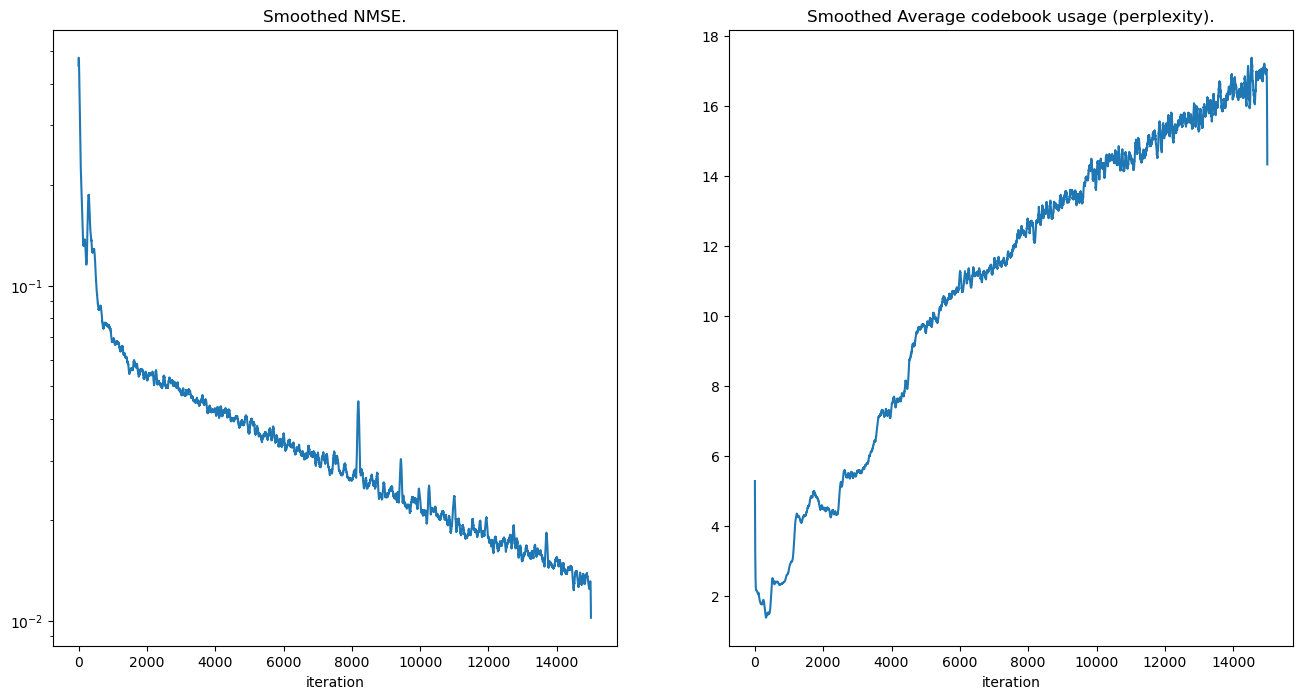

In [26]:
from scipy.signal import savgol_filter
train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 201, 7)
train_res_perplexity_smooth = savgol_filter(train_res_perplexity, 201, 7)

f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error_smooth)
ax.set_yscale('log')
ax.set_title('Smoothed NMSE.')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity_smooth)
ax.set_title('Smoothed Average codebook usage (perplexity).')
ax.set_xlabel('iteration')
     

In [27]:
torch.save(model, 'pixelcnnforcancerarea2.pt')

In [28]:
model.eval()

test_batch = next(iter(test_loader))
test_originals = test_batch.to(device)

vq_output_eval = model.pre_vq_conv(model.encoder(test_originals))
_, test_quantize, _, _, _ = model.vq_vae(vq_output_eval)
test_reconstructions = model.decoder(test_quantize)

In [29]:
def show(img):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


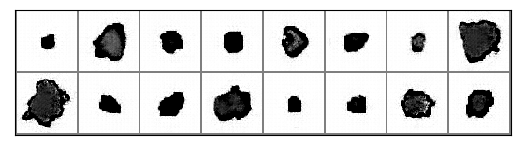

In [30]:
from torchvision.utils import make_grid
show(make_grid(test_reconstructions.cpu().data)+0.5, )

In [31]:
torch.save(model, 'vqvae2.pt')

In [32]:
model = torch.load('vqvae2.pt')

In [33]:
latent_blocks = []

for batch in tqdm(train_loader):
  batch = batch.to(device)

  batch_encoded = model.encoder(batch)
  batch_encoded_conv = model.pre_vq_conv(batch_encoded)
  _, _, _, _, min_encoding_indices = model.vq_vae(batch_encoded_conv)
  latent_blocks.append(min_encoding_indices)

100%|██████████| 36/36 [00:00<00:00, 49.50it/s]


In [34]:
for i in range(len(latent_blocks)):
    latent_blocks[i] = latent_blocks[i].view(-1, 16, 16)

In [35]:
latent_blocks_stacked = torch.cat(latent_blocks)
latent_blocks_stacked = latent_blocks_stacked.cpu()
latent_blocks_stacked.shape

torch.Size([566, 16, 16])

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
from torch.distributions import kl_divergence

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        try:
            nn.init.xavier_uniform_(m.weight.data)
            m.bias.data.fill_(0)
        except AttributeError:
            print("Skipping initialization of ", classname)



class GatedActivation(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        x, y = x.chunk(2, dim=1)
        return F.tanh(x) * F.sigmoid(y)


class GatedMaskedConv2d(nn.Module):
    def __init__(self, mask_type, dim, kernel, residual=True, n_classes=10):
        super().__init__()
        assert kernel % 2 == 1, print("Kernel size must be odd")
        self.mask_type = mask_type
        self.residual = residual

        self.class_cond_embedding = nn.Embedding(
            n_classes, 2 * dim
        )

        kernel_shp = (kernel // 2 + 1, kernel)  # (ceil(n/2), n)
        padding_shp = (kernel // 2, kernel // 2)
        self.vert_stack = nn.Conv2d(
            dim, dim * 2,
            kernel_shp, 1, padding_shp
        )

        self.vert_to_horiz = nn.Conv2d(2 * dim, 2 * dim, 1)

        kernel_shp = (1, kernel // 2 + 1)
        padding_shp = (0, kernel // 2)
        self.horiz_stack = nn.Conv2d(
            dim, dim * 2,
            kernel_shp, 1, padding_shp
        )

        self.horiz_resid = nn.Conv2d(dim, dim, 1)

        self.gate = GatedActivation()

    def make_causal(self):
        self.vert_stack.weight.data[:, :, -1].zero_()  # Mask final row
        self.horiz_stack.weight.data[:, :, :, -1].zero_()  # Mask final column

    def forward(self, x_v, x_h, h):
        if self.mask_type == 'A':
            self.make_causal()

        h = self.class_cond_embedding(h)
        h_vert = self.vert_stack(x_v)
        h_vert = h_vert[:, :, :x_v.size(-1), :]
        out_v = self.gate(h_vert + h[:, :, None, None])

        h_horiz = self.horiz_stack(x_h)
        h_horiz = h_horiz[:, :, :, :x_h.size(-2)]
        v2h = self.vert_to_horiz(h_vert)

        out = self.gate(v2h + h_horiz + h[:, :, None, None])
        if self.residual:
            out_h = self.horiz_resid(out) + x_h
        else:
            out_h = self.horiz_resid(out)

        return out_v, out_h


class GatedPixelCNN(nn.Module):
    def __init__(self, input_dim=256, dim=64, n_layers=15, n_classes=1):
        super().__init__()
        self.dim = dim

        # Create embedding layer to embed input
        self.embedding = nn.Embedding(input_dim, dim)

        # Building the PixelCNN layer by layer
        self.layers = nn.ModuleList()

        # Initial block with Mask-A convolution
        # Rest with Mask-B convolutions
        for i in range(n_layers):
            mask_type = 'A' if i == 0 else 'B'
            kernel = 7 if i == 0 else 3
            residual = False if i == 0 else True

            self.layers.append(
                GatedMaskedConv2d(mask_type, dim, kernel, residual, n_classes)
            )

        # Add the output layer
        self.output_conv = nn.Sequential(
            nn.Conv2d(dim, 512, 1),
            nn.ReLU(True),
            nn.Conv2d(512, input_dim, 1)
        )

        self.apply(weights_init)

    def forward(self, x, label):
        shp = x.size() + (-1, )
        x = self.embedding(x.view(-1)).view(shp)  # (B, H, W, C)
        x = x.permute(0, 3, 1, 2)  # (B, C, W, H)

        x_v, x_h = (x, x)
        for i, layer in enumerate(self.layers):
            x_v, x_h = layer(x_v, x_h, label)

        return self.output_conv(x_h)

    def generate(self, label, shape=(16, 16), batch_size=64):
        param = next(self.parameters())
        x = torch.zeros(
            (batch_size, *shape),
            dtype=torch.int64, device=param.device
        )

        for i in range(shape[0]):
            for j in range(shape[1]):
                logits = self.forward(x, label)
                probs = F.softmax(logits[:, :, i, j], -1)
                x.data[:, i, j].copy_(
                    probs.multinomial(1).squeeze().data
                )
        return x

In [17]:
class LatentBlockDataset(Dataset):
    def __init__(self, data: torch.Tensor):
        super().__init__()
        self.data = data

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        label = 0
        return self.data[index], label

In [18]:
import torchvision.transforms as T
# transform_latent = T.Compose([
#     T.ToTensor()
# ])
df_latent = LatentBlockDataset(latent_blocks_stacked)

NameError: name 'latent_blocks_stacked' is not defined

In [39]:
loader_latent = DataLoader(df_latent, batch_size=16, shuffle=True, num_workers=2)

In [40]:
model_pixelcnn = GatedPixelCNN(num_embeddings, 16**2, 10, 1).to(device)
criterion = nn.CrossEntropyLoss().cuda()
opt = torch.optim.Adam(model_pixelcnn.parameters(), lr=3e-4)

Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d


In [21]:
print(sum(p.numel() for p in model_pixelcnn.parameters()))

17456640


In [41]:
def train():
    train_loss = []
    for batch_idx, (x, label) in tqdm(enumerate(loader_latent)):

        # Train PixelCNN with images
        x = x.to(device)
        label = label.to(device)

        logits = model_pixelcnn(x, label)
        logits = logits.permute(0, 2, 3, 1).contiguous()

        loss = criterion(
            logits.view(-1, num_embeddings),
            x.view(-1)
        )

        opt.zero_grad()
        loss.backward()
        opt.step()

        train_loss.append(loss.item())

        if (batch_idx + 1) % 100 == 0:
            print('\tIter: [{}/{} ({:.0f}%)]\tLoss: {}'.format(
                batch_idx * len(x), 15000,
                100 * batch_idx / len(loader_latent),
                np.asarray(train_loss)[-100:].mean(0)
            ))

In [42]:
train()

0it [00:00, ?it/s]/home/a.pak/.conda/envs/u-net/lib/python3.7/site-packages/torch/nn/functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/a.pak/.conda/envs/u-net/lib/python3.7/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
36it [00:02, 15.81it/s]


In [43]:
epochs = 10
for i in range(epochs):
    print(f'epoch {i}')
    train()
    print('------------------------------------------------')

epoch 0


36it [00:02, 15.94it/s]

------------------------------------------------
epoch 1



36it [00:02, 15.45it/s]

------------------------------------------------
epoch 2



36it [00:02, 15.93it/s]

------------------------------------------------
epoch 3



36it [00:02, 16.01it/s]

------------------------------------------------
epoch 4



36it [00:02, 15.08it/s]

------------------------------------------------
epoch 5



36it [00:02, 14.37it/s]

------------------------------------------------
epoch 6



36it [00:02, 15.91it/s]

------------------------------------------------
epoch 7



36it [00:02, 15.94it/s]

------------------------------------------------
epoch 8



36it [00:02, 15.97it/s]

------------------------------------------------
epoch 9



36it [00:02, 15.82it/s]

------------------------------------------------


In [44]:
opt = torch.optim.Adam(model_pixelcnn.parameters(), lr=1e-4)
epochs = 10
for i in range(epochs):
    print(f'epoch {i}')
    train()
    print('------------------------------------------------')

epoch 0


36it [00:02, 15.08it/s]

------------------------------------------------
epoch 1



36it [00:02, 15.19it/s]

------------------------------------------------
epoch 2



36it [00:02, 15.87it/s]

------------------------------------------------
epoch 3



36it [00:02, 15.88it/s]

------------------------------------------------
epoch 4



36it [00:02, 15.98it/s]

------------------------------------------------
epoch 5



36it [00:02, 15.72it/s]

------------------------------------------------
epoch 6



36it [00:02, 15.82it/s]

------------------------------------------------
epoch 7



36it [00:02, 15.81it/s]

------------------------------------------------
epoch 8



36it [00:02, 15.75it/s]

------------------------------------------------
epoch 9



36it [00:02, 16.00it/s]

------------------------------------------------


In [45]:
opt = torch.optim.Adam(model_pixelcnn.parameters(), lr=5e-5)
epochs = 10
for i in range(epochs):
    print(f'epoch {i}')
    train()
    print('------------------------------------------------')

epoch 0


36it [00:02, 15.09it/s]

------------------------------------------------
epoch 1



36it [00:02, 15.95it/s]

------------------------------------------------
epoch 2



36it [00:02, 15.74it/s]

------------------------------------------------
epoch 3



36it [00:02, 15.82it/s]

------------------------------------------------
epoch 4



36it [00:02, 15.85it/s]

------------------------------------------------
epoch 5



36it [00:02, 15.83it/s]

------------------------------------------------
epoch 6



36it [00:02, 15.87it/s]

------------------------------------------------
epoch 7



36it [00:02, 15.90it/s]

------------------------------------------------
epoch 8



36it [00:02, 15.94it/s]

------------------------------------------------
epoch 9



36it [00:02, 15.75it/s]

------------------------------------------------


In [46]:
torch.save(model_pixelcnn, 'pixelcnn2.pt')

In [47]:
from torchvision.utils import make_grid
def generate_samples():
    label = torch.arange(1).expand(4, 4).contiguous().view(-1)
    label = label.long().to(device)

    x_tilde = model_pixelcnn.generate(label, shape=(16, 16), batch_size=16)
    output = model.vq_vae.embedding(x_tilde).permute(0, 3, 1, 2)
    output = model.decoder(output)
    show(make_grid(output.cpu().data)+0.5, )
    return output

In [48]:
def show(img):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

In [49]:
import numpy as np

# Предположим, что output имеет размер (batch_size, channels, height, width)
# Например, (16, 1, 64, 64) для изображений размером 64x64 с 1 каналом (градации серого)

# Создаем список для хранения преобразованных в numpy array output
generated_dataset = []
for i in range(50):
    # Проходимся по каждому изображению в output
    label = torch.arange(1).expand(4, 4).contiguous().view(-1)
    label = label.long().to(device)
    x_tilde = model_pixelcnn.generate(label, shape=(16, 16), batch_size=16)
    output = model.vq_vae.embedding(x_tilde).permute(0, 3, 1, 2)
    output = model.decoder(output)
    for img_idx in range(output.shape[0]):
        # Получаем текущее изображение
        current_img = output[img_idx]

        # Преобразуем изображение в numpy array
        current_img_np = current_img.squeeze().cpu().detach().numpy()  # Убираем размерность каналов и преобразуем в numpy array

        # Добавляем изображение в датасет
        generated_dataset.append(current_img_np)

# Теперь у вас есть датасет, где каждая строка содержит один сгенерированный output в формате numpy array
print("Размер датасета:", len(generated_dataset))


Размер датасета: 800


In [50]:
# Создаем датафрейм из списка numpy массивов
df_new = pd.DataFrame({'generated_images': generated_dataset})

# Теперь у вас есть датафрейм, где каждая строка содержит одно сгенерированное изображение в виде numpy массива
print("Размер датафрейма:", df_new.shape)

Размер датафрейма: (800, 1)


In [51]:
df_new.to_pickle("df_generated_cencer_by_vae2.pkl")

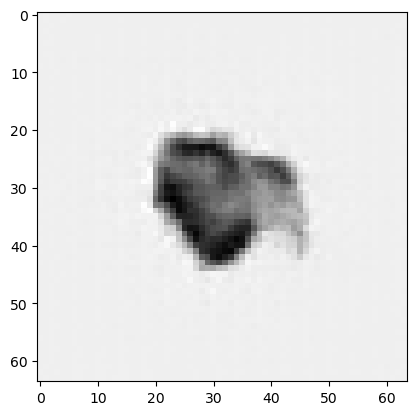

In [52]:
plt.imshow(df_new['generated_images'][20],cmap = "gray")

In [53]:
len(df_new)

800

In [54]:
780/16

48.75

In [55]:
import matplotlib.pyplot as plt

def plot_images(images, rows=8, cols=8, figsize=(10, 10)):
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i], cmap='gray')
        ax.axis('off')
        ax.set_aspect('auto')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['top'].set_visible(i < cols)
        ax.spines['right'].set_visible(i < cols)
        ax.spines['bottom'].set_visible(i >= cols * (rows - 1))
        ax.spines['left'].set_visible(i % cols == 0)
    plt.tight_layout()
    plt.show()



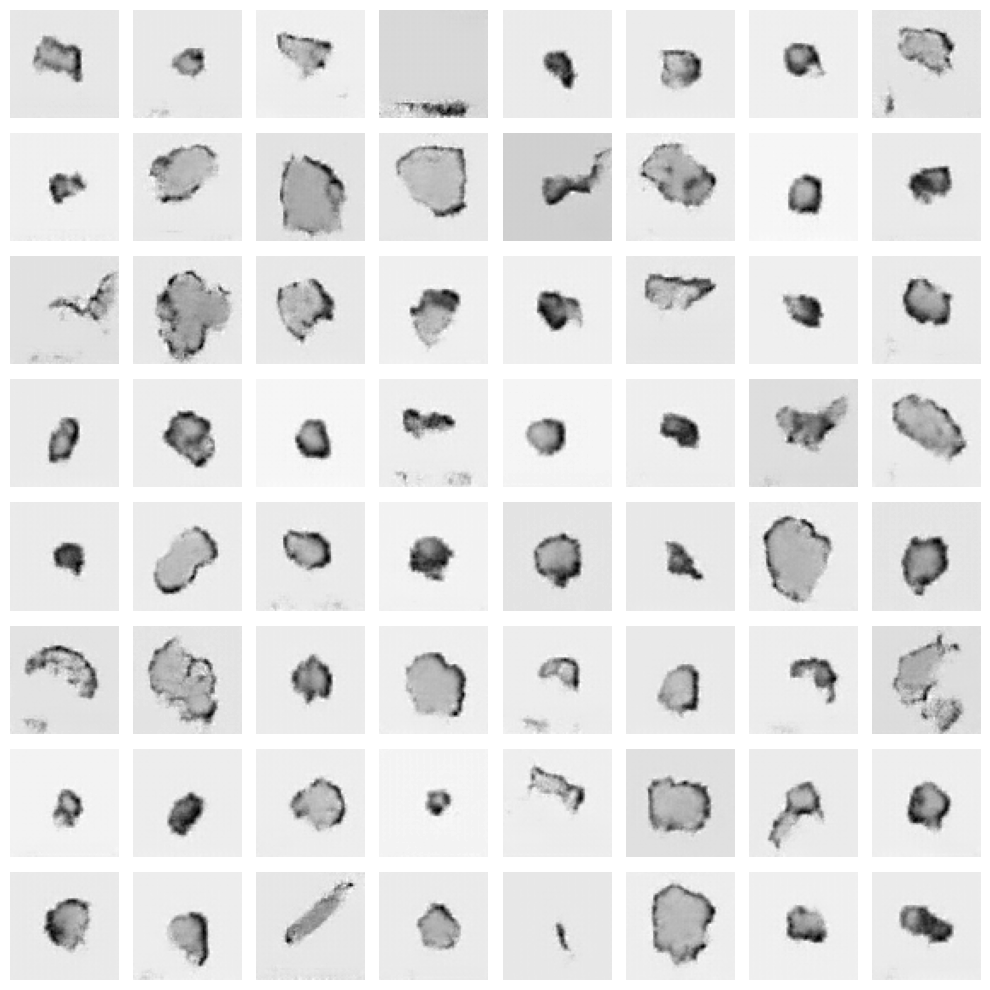

In [56]:
# Generated
plot_images(df_new['generated_images'].values, rows=8, cols=8)

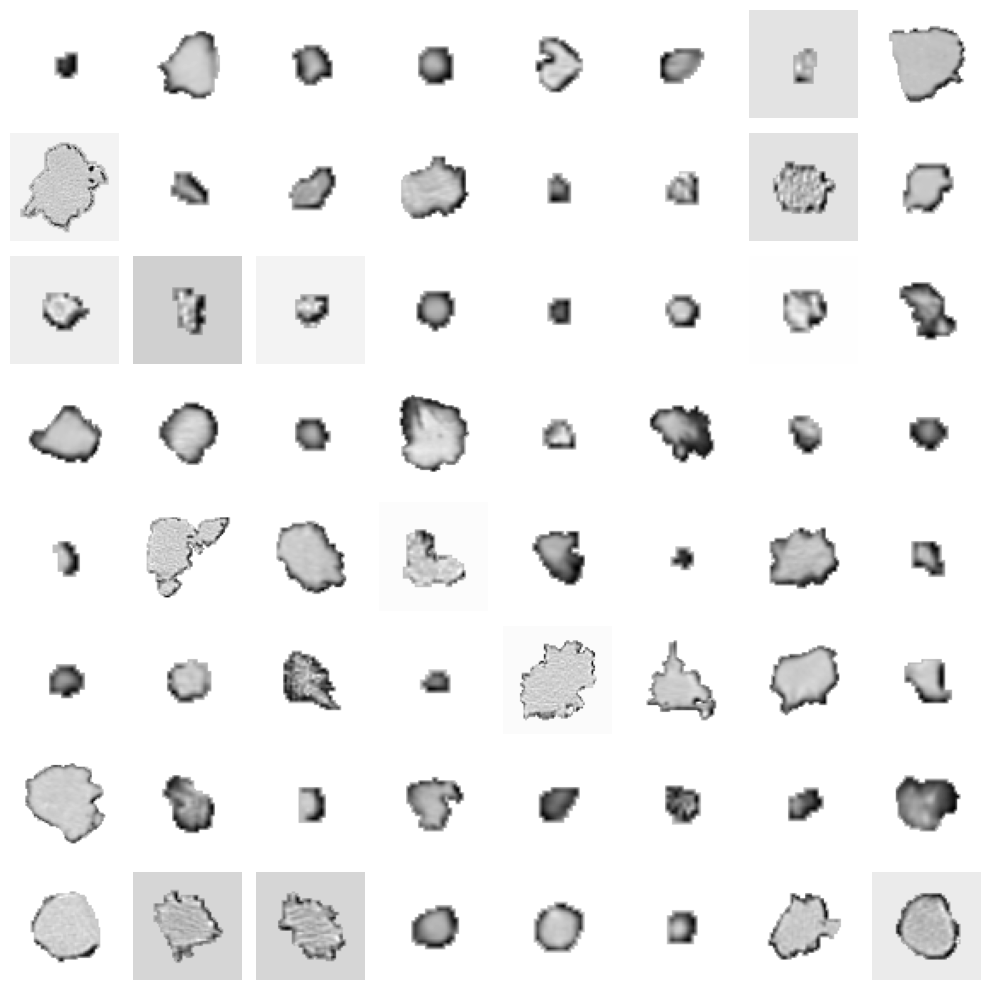

In [57]:
# Real
plot_images(test_df['roi'].values, rows=8, cols=8)

In [58]:
(df_new['generated_images'][0]<= np.mean(df_new['generated_images'][0]))

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [59]:
np.mean(df_new['generated_images'][0])

0.26076978

In [63]:
np.max(df_new['generated_images'][0])

0.9641931